# Session 11

## Cloning the repo

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
%cd /content/drive/MyDrive/Github/ERA-v1

/content/drive/MyDrive/Github/ERA-v1


In [17]:
! git config --global user.email "me18b059@smail.iitm.ac.in"
# ! git stash push --include-untracked
# ! git stash drop
! git pull

remote: Enumerating objects: 9, done.
remote: Counting objects: 100% (9/9), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 5 (delta 4), reused 5 (delta 4), pack-reused 0
Unpacking objects: 100% (5/5), 398 bytes | 8.00 KiB/s, done.
From https://github.com/Madhur-1/ERA-v1
   3cabe32..94756f3  master     -> origin/master
Updating 3cabe32..94756f3
Fast-forward
 S11/Utilities/model.py | 4 ++--
 1 file changed, 2 insertions(+), 2 deletions(-)


In [18]:
%cd S11/

[Errno 2] No such file or directory: 'S11/'
/content/drive/MyDrive/Github/ERA-v1/S11


# CIFAR-10 dataset classification

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

The dataset is divided into five training batches and one test batch, each with 10000 images. The test batch contains exactly 1000 randomly-selected images from each class. The training batches contain the remaining images in random order, but some training batches may contain more images from one class than another. Between them, the training batches contain exactly 5000 images from each class.

# Importing basic dependencies

In [5]:
!pip install torchmetrics
!pip install torch_lr_finder
!pip install grad-cam

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# del model
import torch
import torch.nn as nn
import torch.optim as optim
from Utilities.model import ResNet18
from Utilities.utils import train, test
import torch.nn.functional as F
from torchsummary import summary

torch.manual_seed(1)

In [3]:
CLASSES = ("Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck")

# Model Initialization & Summary

In [4]:
# device = torch.device("cuda")
model = ResNet18()
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
            Conv2d-3           [-1, 64, 32, 32]          36,864
       BatchNorm2d-4           [-1, 64, 32, 32]             128
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
        BasicBlock-7           [-1, 64, 32, 32]               0
            Conv2d-8           [-1, 64, 32, 32]          36,864
       BatchNorm2d-9           [-1, 64, 32, 32]             128
           Conv2d-10           [-1, 64, 32, 32]          36,864
      BatchNorm2d-11           [-1, 64, 32, 32]             128
       BasicBlock-12           [-1, 64, 32, 32]               0
           Conv2d-13          [-1, 128, 16, 16]          73,728
      BatchNorm2d-14          [-1, 128,

In [15]:
from Utilities.dataset import get_dataloaders

batch_size = 512

kwargs = {'batch_size': batch_size, 'shuffle': True, 'num_workers': 4, 'pin_memory': True}
train_loader, test_loader = get_dataloaders(train_transforms=train_transforms, test_transforms=test_transforms, **kwargs)

Files already downloaded and verified
Files already downloaded and verified


# Data Exploration

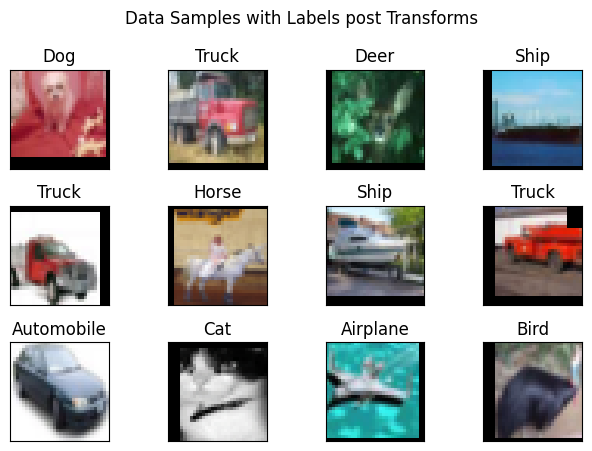

In [25]:
from Utilities.visualize import plot_data_samples, plot_class_label_counts

# plot_class_label_counts(train_loader, classes=CLASSES)
plot_data_samples(train_loader, classes=CLASSES)

# Training

  0%|          | 0/200 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 1.83E-03


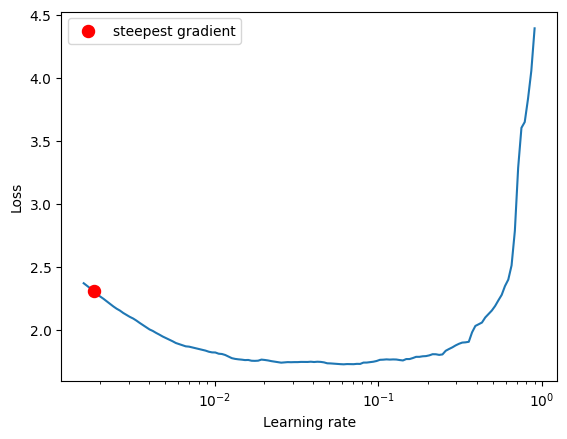

In [31]:
from torch_lr_finder import LRFinder
model = ResNet18(dropout_percentage=0.1).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)
criterion = F.cross_entropy

lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [32]:
from torch.optim.lr_scheduler import OneCycleLR

EPOCHS = 20

scheduler = OneCycleLR(
        optimizer,
        max_lr=1.83E-03,
        steps_per_epoch=len(train_loader),
        epochs=EPOCHS,
        pct_start=5/EPOCHS,
        div_factor=100,
        three_phase=False,
        final_div_factor=100,
        anneal_strategy='linear'
    )

# Data to plot accuracy and loss graphs
train_losses = []
test_losses = []
train_accs = []
test_accs = []

for epoch in range(1, EPOCHS+1):
  print(f'Epoch {epoch}')
  train_accs, train_losses = train(model, device, train_loader, optimizer, criterion, scheduler, train_losses, train_accs)
  test_accs, test_losses = test(model, device, test_loader, criterion, test_losses, test_accs)

Epoch 1


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Train: 100% Loss=1.2753 Batch_id=97 Accuracy=38.80
Test set: Average loss: 1.8724, Accuracy: 4206/10000 (42.06%)

Epoch 2
Train: 100% Loss=1.1181 Batch_id=97 Accuracy=57.95
Test set: Average loss: 1.1259, Accuracy: 6162/10000 (61.62%)

Epoch 3
Train: 100% Loss=0.7592 Batch_id=97 Accuracy=67.57
Test set: Average loss: 1.2246, Accuracy: 6335/10000 (63.35%)

Epoch 4
Train: 100% Loss=0.7228 Batch_id=97 Accuracy=73.94
Test set: Average loss: 1.0824, Accuracy: 6614/10000 (66.14%)

Epoch 5
Train: 100% Loss=0.6543 Batch_id=97 Accuracy=78.00
Test set: Average loss: 0.8078, Accuracy: 7354/10000 (73.54%)

Epoch 6
Train: 100% Loss=0.5021 Batch_id=97 Accuracy=81.00
Test set: Average loss: 1.0121, Accuracy: 7076/10000 (70.76%)

Epoch 7
Train: 100% Loss=0.4954 Batch_id=97 Accuracy=83.70
Test set: Average loss: 0.9157, Accuracy: 7323/10000 (73.23%)

Epoch 8
Train: 100% Loss=0.3594 Batch_id=97 Accuracy=86.15
Test set: Average loss: 0.6932, Accuracy: 7806/10000 (78.06%)

Epoch 9
Train: 100% Loss=0.4149 

In [33]:
import pandas as pd
bn_df = pd.DataFrame({'Train Acc': train_accs, 'Test Acc': test_accs, 'Train Loss': train_losses, 'Test Loss': test_losses})
bn_df.to_csv('Store/training_stats.csv', index=False)

In [35]:
import pandas as pd
bn_train = pd.read_csv("Store/training_stats.csv")
bn_train
train_accs = bn_train['Train Acc'].tolist()
test_accs = bn_train['Test Acc'].tolist()
train_losses = bn_train['Train Loss'].tolist()
test_losses = bn_train['Test Loss'].tolist()

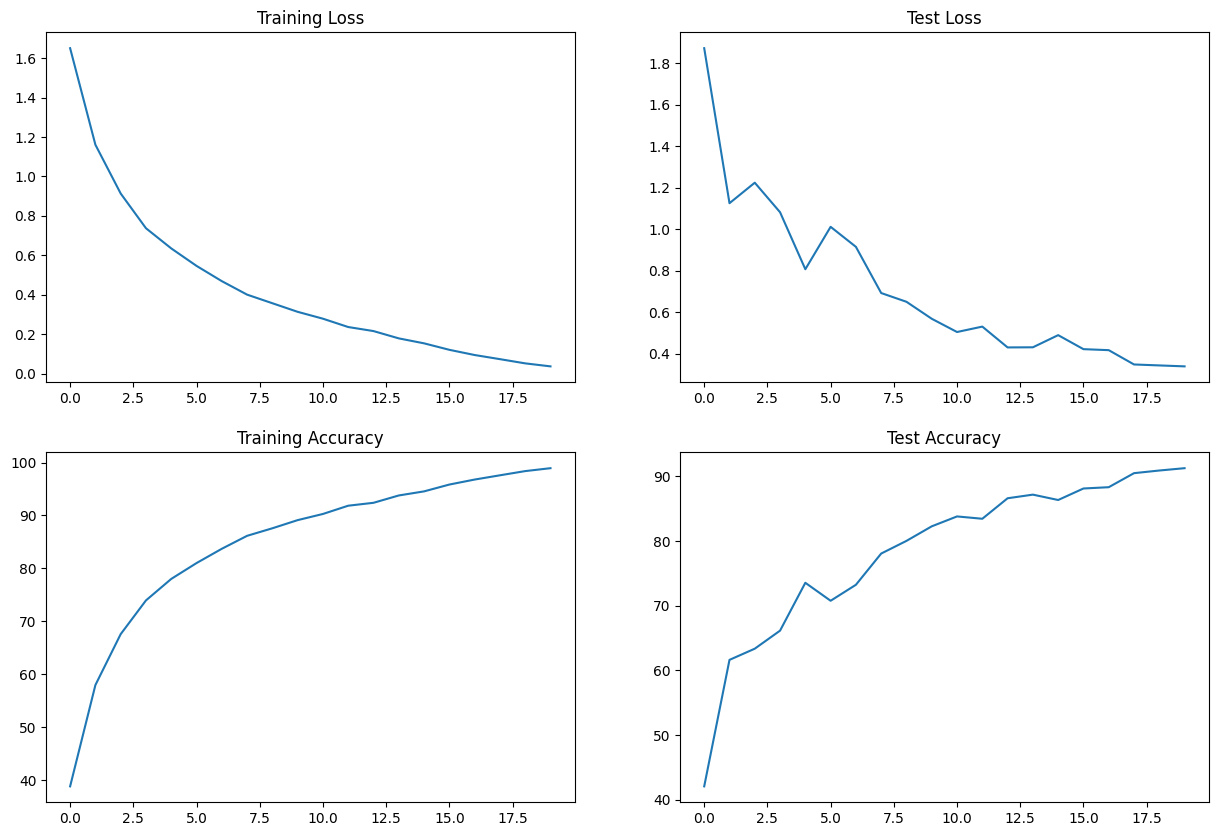

In [36]:
from Utilities.visualize import plot_model_training_curves

plot_model_training_curves(train_accs=train_accs, test_accs=test_accs, train_losses=train_losses, test_losses=test_losses)

# Model Analysis

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


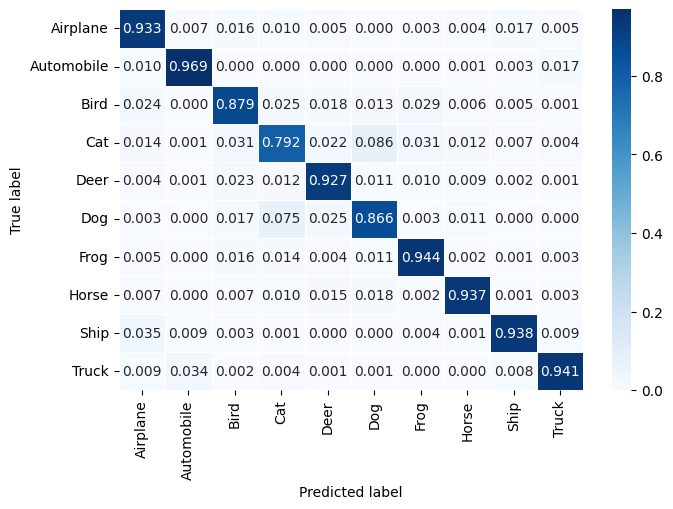

In [37]:
from Utilities.utils import get_all_and_incorrect_preds
from Utilities.visualize import plot_confusion_matrix

all_preds, all_labels, incorrect = get_all_and_incorrect_preds(model=model, loader=test_loader, device=device)
plot_confusion_matrix(all_labels, all_preds, classes=CLASSES)

Total Incorrect Predictions 874


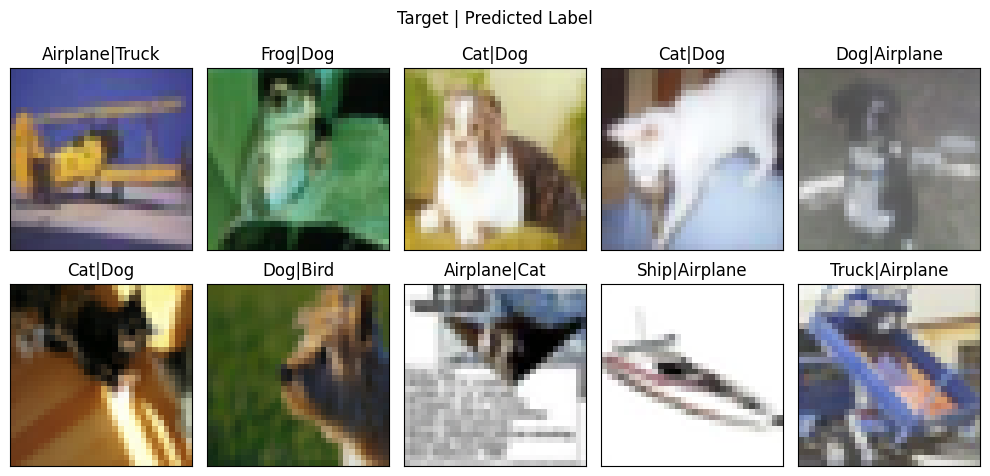

In [38]:
from Utilities.visualize import plot_incorrect_preds

plot_incorrect_preds(incorrect, classes=CLASSES)

In [ ]:
# from pytorch_grad_cam import GradCAM
# from pytorch_grad_cam.utils.image import show_cam_on_image
# from torchvision.models import resnet18
# from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
# import numpy as np

# target_layers = [model.layer4[-1]]
# batch_idx, (input_tensor, target) = next(enumerate(train_loader))
# # input_tensor = torch.zeros(size=(1,3,32,32))
# # model=resnet18(pretrained=True)
# # Construct the CAM object once, and then re-use it on many images:
# cam = GradCAM(model=model, target_layers=target_layers, use_cuda=torch.cuda.is_available())

# # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
# grayscale_cam = cam(input_tensor=input_tensor, targets=None)

# # In this example grayscale_cam has only one image in the batch:
# grayscale_cam = grayscale_cam[0, :]

unnormalized = transforms.Normalize(
            (-1.98947368, -1.98436214, -1.71072797), (4.048583, 4.11522634, 3.83141762)
        )(input_tensor[0, :])
visualization = show_cam_on_image(unnormalized.permute(1, 2, 0).detach().numpy(), grayscale_cam, use_rgb=True, image_weight=0.75)

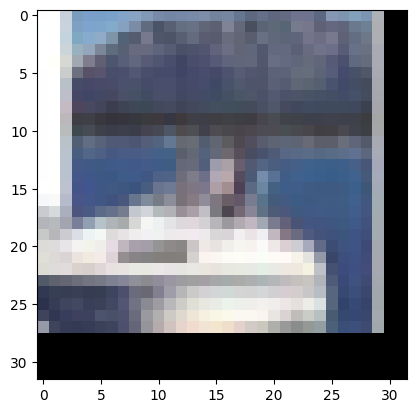

In [ ]:
from torchvision import transforms
unnormalized = transforms.Normalize(
            (-1.98947368, -1.98436214, -1.71072797), (4.048583, 4.11522634, 3.83141762)
        )(input_tensor[0, :])
plt.imshow(transforms.ToPILImage()(unnormalized))

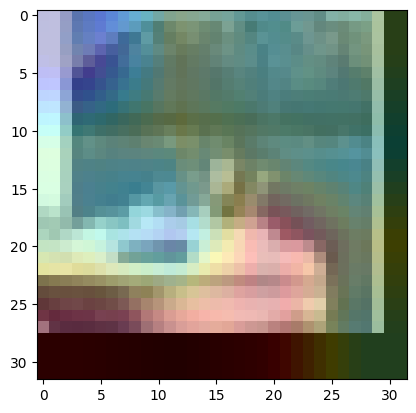

In [ ]:
plt.imshow(transforms.ToPILImage()(visualization))

# Dataset & Dataloaders

In [ ]:
from Utilities.transforms import train_transforms, test_transforms

### Git Push

In [39]:
!git add .
! git commit -m "S11 commit 91.26%"
! git push

[master 8fbf755] S11 commit 91.26%
 1 file changed, 21 insertions(+), 25 deletions(-)
 rewrite S11/Store/training_stats.csv (96%)
Enumerating objects: 9, done.
Counting objects: 100% (9/9), done.
Delta compression using up to 2 threads
Compressing objects: 100% (4/4), done.
Writing objects: 100% (5/5), 937 bytes | 234.00 KiB/s, done.
Total 5 (delta 2), reused 0 (delta 0), pack-reused 0
remote: Resolving deltas: 100% (2/2), completed with 2 local objects.
To https://github.com/Madhur-1/ERA-v1
   94756f3..8fbf755  master -> master
